In [1]:
# This program is used to simulate gravimeter data, inject kicks and
# Simulate data retrival algoirthms through various noise sources.


#importing libraries
import csv
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
from scipy import signal
from scipy.optimize import curve_fit
from os import listdir
from os.path import isfile, join
import pylab
import numpy as np
import datetime


def gaussian(x,bb,cc,dd):
    hold=bb*np.exp(-1*(x-cc)**2/(2*dd**2))
    return hold




def data_trim(xdata,ydata,threshold):
    outx=[]
    outy=[]
    for i in range(len(xdata)):
        if np.abs(ydata[i])<threshold:
            outx.append(xdata[i])
            outy.append(ydata[i])
    return([outx,outy])

def data_trim_1D(ydata,threshold):
    outy=[]
    for i in range(len(ydata)):
        if np.abs(ydata[i])<threshold:
            outy.append(ydata[i])
    return(outy)

def outlier_reject_mean(datas,sigma_rej):
    import numpy as np
    mean_val=np.mean(datas)
    std_val=np.std(datas)
    dropped= [x for x in datas if -1*sigma_rej*std_val<=x-mean_val<=sigma_rej*std_val]
    return(np.mean(dropped),np.divide(np.std(dropped),np.sqrt(len(dropped))))

def outlier_reject_median(datas,sigma_rej):
    import numpy as np
    mean_val=np.median(datas)
    std_val=np.std(datas)
    dropped= [x for x in datas if -1*sigma_rej*std_val<=x-mean_val<=sigma_rej*std_val]
    return(np.mean(dropped),np.divide(np.std(dropped),np.sqrt(len(dropped))))


def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    outlier_ind=modified_z_score > thresh
    meanval=np.mean([points[i] for i in range(len(points)) if outlier_ind[i]==False])
    return meanval

# This looks for general domain walls, by fitting region widthb to the left, a region
# width b to the left, and seeing how those two regions disagree and the center
# Basically looks for step discontinuit
def Long_Region_N_Point_Poly_Filter(t,signal1,widthb,order):
    import numpy as np
    output=[]
    t_filt=[]
    for i in range(len(t)):
        if widthb+1<i<(len(t)-widthb-1):
            fit_regionx_left=t[i-widthb:i]
            fit_regiony_left=signal1[i-widthb:i]
            fit_regionx_right=t[i+1:i+widthb+1]
            fit_regiony_right=signal1[i+1:i+widthb+1]    
            if fit_regionx_right[-1]-fit_regionx_left[0]==(widthb*2)*60:
                p_left=np.polyfit(fit_regionx_left,fit_regiony_left,order)
                p_right=np.polyfit(fit_regionx_right,fit_regiony_right,order)
                gap=np.poly1d(p_right)(t[i])-np.poly1d(p_left)(t[i])
                output.append(gap)
                t_filt.append(t[i])                
            else:
                gaps=1
    return(t_filt,output)


def N_Point_Poly_Filter(t,signal1,widthb,widthr,order):
    import numpy as np
    output=[]
    t_filt=[]
    for i in range(len(t)):
        if widthb+widthr<i<(len(t)-widthb-widthr):
            fit_regionx=t[i-(widthr+widthb):i-widthr]+t[i+widthr+1:i+widthr+widthb+1]
            fit_regiony=signal1[i-(widthr+widthb):i-widthr]+signal1[i+widthr+1:i+widthr+widthb+1]
            p=np.polyfit(fit_regionx,fit_regiony,order)
            sample_regionx=t[i-widthr:i]+t[i:i+widthr+1]
            sample_regiony=signal1[i-widthr:i]+signal1[i:i+widthr+1]
            remainder=np.subtract(sample_regiony,list(np.poly1d(p)(sample_regionx)))
            output.append(np.mean(remainder))
            t_filt.append(t[i])
    return(t_filt,output)



from bisect import bisect_left
def index(a, x):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    else: 
        return 'false'
    


In [2]:
# # # This checks the Raw data Visually
save_dir='F:\IGETS Data Raw'
master_dir=listdir(save_dir)


In [3]:
l2dir=save_dir+'\\'+master_dir[0] + '\\ap046\\Level2'+'\\2009\\'
listdir(l2dir)
l2dir+listdir(l2dir)[0]
#[time,signal]=np.load(l2dir+listdir(l2dir)[0]) 

data_test='F:\L2 Analysis\IGETS Each_Sensor_total\\ap046.npy'
#data_test='F:\\IGETS Each_Sensor_total\\ap046.npy'
[time,signal]=np.load(data_test) 

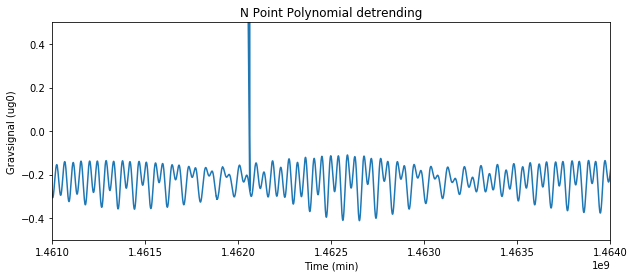

In [4]:
f,ax = plt.subplots(1, figsize=(10,4))
ax.plot(time,signal*1E6)
ax.set_title("N Point Polynomial detrending")
plt.xlabel("Time (min)")
plt.ylabel("Gravsignal (ug0)")
plt.ylim([-.5,.5])
plt.xlim([1.461E9,1.464E9])
plt.show(f)

bf056-2.npy


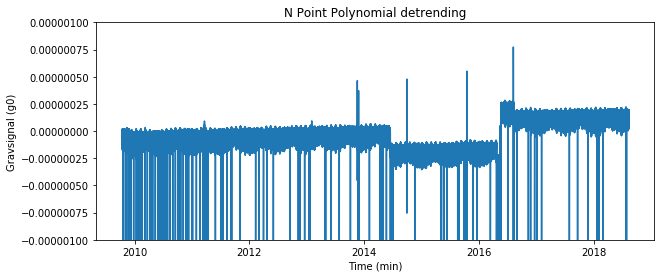

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


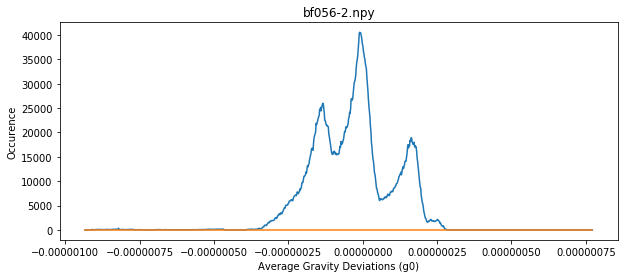

In [100]:
# # # This checks the Raw data Visually
save_dir='F:\\IGETS Each_Sensor_total\\'
data_dir=listdir(save_dir)


p=4
print(data_dir[p])
[time,signal]=np.load(save_dir+data_dir[p]) 
time=np.add(np.divide(time,365*24*3600),1970)

f,ax = plt.subplots(1, figsize=(10,4))
ax.plot(time,signal)
ax.set_title("N Point Polynomial detrending")
plt.xlabel("Time (min)")
plt.ylabel("Gravsignal (g0)")
plt.ylim([-1E-6,1E-6])
plt.show(f)
good_raw=[0,1,2,3,4,7,8,9,13,15,17,18,19,
          20,21,22,23,25,26,27,28,33,39,40,41,42]

great=[20,21,22,23,25,26,27,28]
sus=[12,14,16,19,24,30,31,32,33,35,37,38,42]
amazing=[20,22]
wrong=[31]

qualfilt=1E-5
cutjump=100
time_qual_filt=[]
signal_qual_filt=[]
for j in range(len(time)):
    if np.abs(signal[j])<qualfilt:
        time_qual_filt.append(time[j])
        signal_qual_filt.append(signal[j])
    else:
        j=j+cutjump
            
histbins=1000
histy,histx=np.histogram(signal_qual_filt,bins=histbins)
histx=histx[:-1]-(histx[0]-histx[1])/2
popt,pcov = curve_fit(gaussian,histx,histy,p0=[max(histy),0,2E-11])
f,ax = plt.subplots(1, figsize=(10,4))
ax.plot(histx,histy)
ax.plot(histx,gaussian(histx,*popt))
ax.set_title(data_dir[p])
plt.xlabel("Average Gravity Deviations (g0)")
plt.ylabel("Occurence")
#plt.xlim([-.5E-9,.5E-9])
plt.show()

In [227]:

# This code takes the filtered data, then cuts sections where the noise 
# is abnormally high
good=[0,1,3,4,7,8,9,10,13,15,17,18,19,22,23,26,27,28,33,40,41,42,43,45,46]
maybe=[12,14,25,31]
weird_peaky=[16,20,21,24,29,30,32,35,36,37,38,39,44]

#This pulls just the names of data I have pre-selected to be good
save_dir='F:\\IGETS Each_Sensor_total\\'
data_dir=listdir(save_dir)
good_data=[data_dir[i] for i in good]

#Here I load this preselected good data, after it has been filtered
filtered_dir='F:\\IGETS Data Long NPoly Filter\\'
filtered_dir='F:\\IGETS Data Long NPoly Filter Qual Trim\\'


times_vec=[]
sig_vec=[]
for i in range(len(good_data)):
    [time,filt_signal1]=np.load(filtered_dir+good_data[i]) 
    times_vec.append(time)
    sig_vec.append(filt_signal1)
    print(good_data[i])
    


ap046.npy
ba009.npy
bf056-1.npy
bf056-2.npy
bh030-1.npy
bh030-2.npy
bh044.npy
bo024.npy
cb031.npy
dj060.npy
hs048.npy
ka016.npy
ky009.npy
lp038.npy
ma011.npy
me020.npy
me073-1.npy
me073-2.npy
pe050.npy
tc038.npy
vi025.npy
we006.npy
we029-1.npy
we030-1.npy
we030-2.npy


cb031.npy


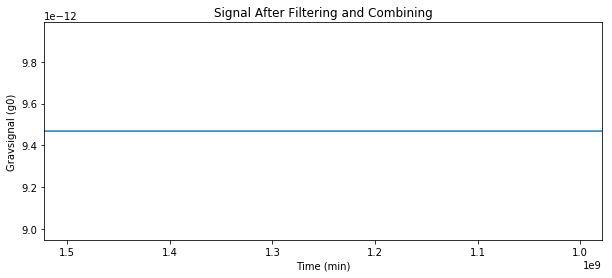

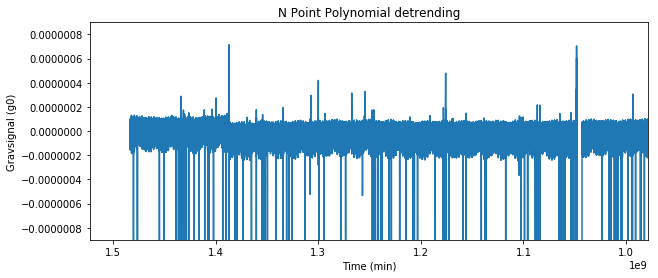

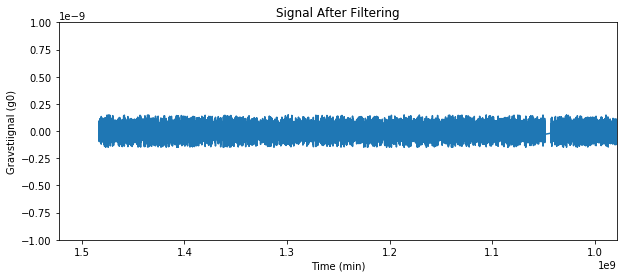

In [228]:
check=8
save_dir_raw='F:\\IGETS Each_Sensor_total\\'
print(good_data[check])

f,ax = plt.subplots(1, figsize=(10,4))
ax.plot(time_real,filt_signal)
ax.set_title("Signal After Filtering and Combining")
plt.xlim([time_real[start],time_real[start+3*width]])
plt.xlabel("Time (min)")
plt.ylabel("Gravsignal (g0)")
plt.show(f)

[time,signal]=np.load(save_dir_raw+good_data[check]) 
f,ax = plt.subplots(1, figsize=(10,4))
ax.plot(time,signal)
ax.set_title("N Point Polynomial detrending")
plt.xlabel("Time (min)")
plt.ylabel("Gravsignal (g0)")
plt.xlim([time_real[start],time_real[start+3*width]])
plt.ylim([-9E-7,9E-7])
plt.show(f)


f,ax = plt.subplots(1, figsize=(10,4))
ax.plot(times_vec[check],sig_vec[check])
ax.set_title("Signal After Filtering")
plt.xlim([time_real[start],time_real[start+3*width]])
plt.ylim([-1E-9,1E-9])
plt.xlabel("Time (min)")
plt.ylabel("Gravstiignal (g0)")
plt.show(f)

